In [5]:
import warnings
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from math import sqrt

# sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer

# Mute warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [7]:
data = pd.read_csv("train.csv", index_col="Id")

In [8]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


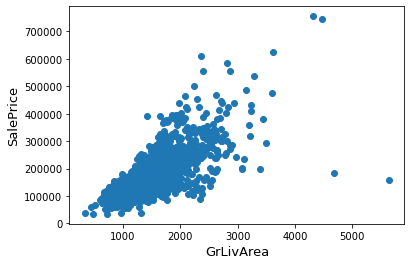

In [9]:
fig, ax = plt.subplots()
ax.scatter(data['GrLivArea'], data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

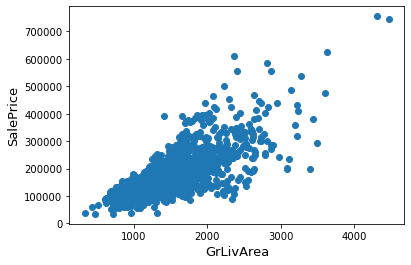

In [10]:
data = data.drop(data[(data['GrLivArea']>4000) & (data['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(data['GrLivArea'], data['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

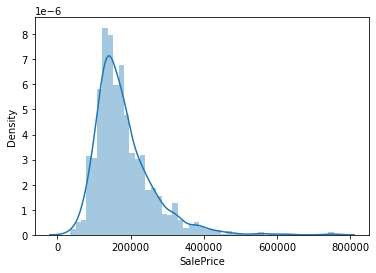

In [11]:
sns.distplot(data['SalePrice']);

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

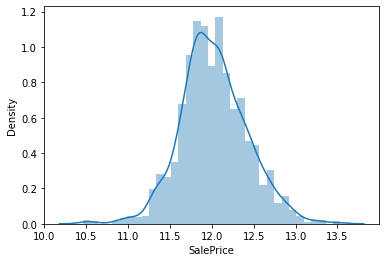

In [12]:
data['SalePrice'] = np.log1p(data['SalePrice'])
sns.distplot(data['SalePrice'])

In [13]:
target = data['SalePrice']
data= data.drop(axis=1, columns='SalePrice')

In [14]:
data.shape

(1458, 79)

In [15]:
ordinal = ['MSZoning', 'LotShape', 'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'HeatingQC', 'CentralAir',
           'KitchenQual', 'GarageQual', 'GarageCond', 'PoolQC']

print('# of Ordinal Categoricals: ' + str(len(ordinal)))


nominal = [var for var in data.columns if data[var].dtype=='O' and var not in ordinal]

print('# of Nominal Categoricals: ' + str(len(nominal)))

# of Ordinal Categoricals: 13
# of Nominal Categoricals: 30


In [16]:
for var in nominal:
    print(var, ': ', data[var].unique())

Street :  ['Pave' 'Grvl']
Alley :  [nan 'Grvl' 'Pave']
LandContour :  ['Lvl' 'Bnk' 'Low' 'HLS']
Utilities :  ['AllPub' 'NoSeWa']
LotConfig :  ['Inside' 'FR2' 'Corner' 'CulDSac' 'FR3']
LandSlope :  ['Gtl' 'Mod' 'Sev']
Neighborhood :  ['CollgCr' 'Veenker' 'Crawfor' 'NoRidge' 'Mitchel' 'Somerst' 'NWAmes'
 'OldTown' 'BrkSide' 'Sawyer' 'NridgHt' 'NAmes' 'SawyerW' 'IDOTRR'
 'MeadowV' 'Edwards' 'Timber' 'Gilbert' 'StoneBr' 'ClearCr' 'NPkVill'
 'Blmngtn' 'BrDale' 'SWISU' 'Blueste']
Condition1 :  ['Norm' 'Feedr' 'PosN' 'Artery' 'RRAe' 'RRNn' 'RRAn' 'PosA' 'RRNe']
Condition2 :  ['Norm' 'Artery' 'RRNn' 'Feedr' 'PosA' 'PosN' 'RRAn' 'RRAe']
BldgType :  ['1Fam' '2fmCon' 'Duplex' 'TwnhsE' 'Twnhs']
HouseStyle :  ['2Story' '1Story' '1.5Fin' '1.5Unf' 'SFoyer' 'SLvl' '2.5Unf' '2.5Fin']
RoofStyle :  ['Gable' 'Hip' 'Gambrel' 'Mansard' 'Flat' 'Shed']
RoofMatl :  ['CompShg' 'WdShngl' 'Metal' 'WdShake' 'Membran' 'Tar&Grv' 'Roll']
Exterior1st :  ['VinylSd' 'MetalSd' 'Wd Sdng' 'HdBoard' 'BrkFace' 'WdShing' 'Cem

In [17]:
year_vars = [var for var in data.columns if 'Yr' in var or 'Year' in var]

year_vars

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [18]:
discrete = [var for var in data.columns if data[var].dtype != 'O'
            # the largest discrete feature 'MSSubClass' has 16 variables
            and len(data[var].unique()) < 17
            and var not in year_vars
            # 'PoolArea' is not discrete, it just has a small # of values
            and var not in ['PoolArea']
            ]

print('# of discrete features: ', len(discrete))


numerical = [var for var in data.columns if data[var].dtype != 'O'
             and var not in discrete
             and var not in year_vars
             and var not in ['Id', 'SalePrice']
            ]

print('# of Continuous Features: ', len(numerical))

# of discrete features:  13
# of Continuous Features:  19


In [19]:
def missing_var(x):
    for var in x:
        if data[var].isnull().sum() > 0:
            print(var, ': ', data[var].isnull().mean())


print('Missing Ordinal Categorical Features: ')
missing_var(ordinal)
print()
            
print('Missing Nominal Categorical Features: ')
missing_var(nominal)
print()

print('Missing Discrete Features: ')
missing_var(discrete)
print()

print('Missing Numerical Features: ')
missing_var(numerical)
print()

print('Missing year_vars Features: ')
missing_var(year_vars)

Missing Ordinal Categorical Features: 
BsmtQual :  0.025377229080932786
BsmtCond :  0.025377229080932786
BsmtExposure :  0.02606310013717421
GarageQual :  0.05555555555555555
GarageCond :  0.05555555555555555
PoolQC :  0.9958847736625515

Missing Nominal Categorical Features: 
Alley :  0.9375857338820301
MasVnrType :  0.0054869684499314125
BsmtFinType1 :  0.025377229080932786
BsmtFinType2 :  0.02606310013717421
Electrical :  0.0006858710562414266
FireplaceQu :  0.4732510288065844
GarageType :  0.05555555555555555
GarageFinish :  0.05555555555555555
Fence :  0.8072702331961591
MiscFeature :  0.9629629629629629

Missing Discrete Features: 

Missing Numerical Features: 
LotFrontage :  0.1776406035665295
MasVnrArea :  0.0054869684499314125

Missing year_vars Features: 
GarageYrBlt :  0.05555555555555555


In [20]:
overFivePerc_cat = ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

# Numerical Features missing more than 5% of its values
overFivePerc_num = ['LotFrontage']

    
##### May need to switch Xtrain mode, median with the whole datasets median, Ill see as i go

    
def impute_missing_vars(df):
    # Converting all the categorical features with less than 5% of its data missing into the
    # most frequent value
    for var in df[ordinal]:
        df[var] = df[var].fillna(data[var].mode()[0])
        
    for var in df[nominal]:
        df[var] = df[var].fillna(data[var].mode()[0])

    
    # Converting all the missing categorical features above 5% into a new value 'None'
    for var in df[overFivePerc_cat]:
        df[var] = df[var].fillna('None')

    
    # Converting all the discrete/numerical features with less than 5% of its data missing into
    # the median value, assuming most are skewed
    for var in df[discrete]:
        df[var] = df[var].fillna(data[var].median())
    
    for var in df[numerical]:
        df[var] = df[var].fillna(data[var].median())

    
    # Converting all the missing numerical features over 5% to 0, representing none
    for var in df[overFivePerc_num]:
        df[var] = df[var].fillna(0)

    # Finally for the missing year_vars im just going to replace them with the median
    for var in df[year_vars]:
        df[var] = df[var].fillna(data[var].median())
    

    
impute_missing_vars(data)

In [21]:
print("# of missing data values : {}".format(data.isna().sum()))

# of missing data values : MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
Street           0
                ..
MiscVal          0
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
Length: 79, dtype: int64


In [22]:
def elapsed_years(df, var):
    # capture difference between year variable and
    # year the house was sold
    df[var] = df['YrSold'] - df[var]
    return df

for var in ['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']:
    data = elapsed_years(data, var)

In [23]:
data.drop('YrSold', axis=1, inplace=True)
year_vars.remove('YrSold')

In [24]:
data[year_vars].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
Id,,,
1,5,5,5.0
2,31,31,31.0
3,7,6,7.0
4,91,36,8.0
5,8,8,8.0


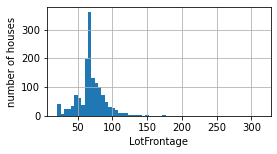

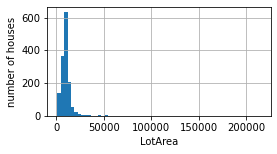

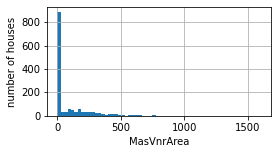

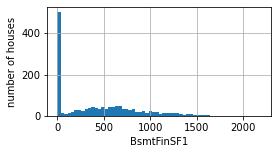

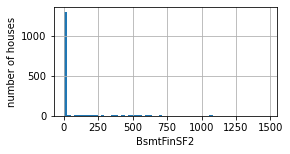

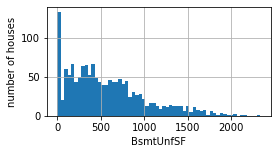

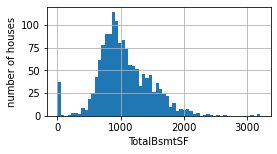

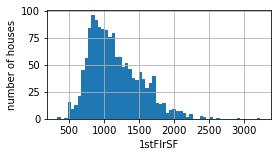

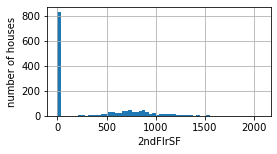

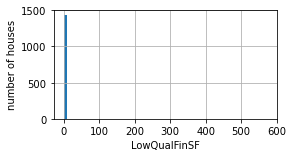

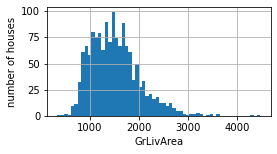

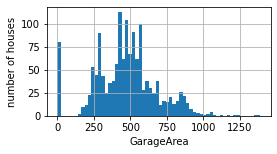

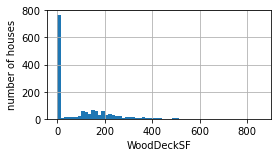

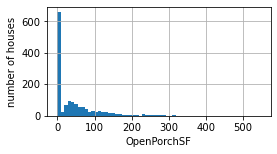

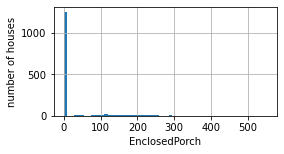

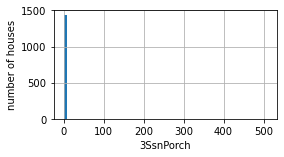

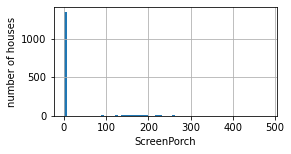

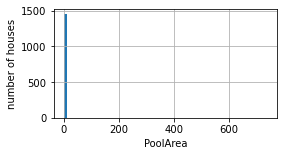

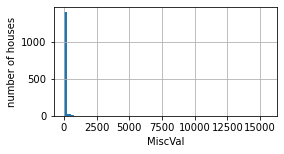

In [25]:
for var in numerical:
    plt.figure(figsize=(4,2))
    fig = data[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)

In [26]:
numToLog = ['LotFrontage','TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'GarageArea']

def logTransform(df, col):
    for col in df[numToLog]:
        df[col] = np.log1p(df[col])

logTransform(data, numToLog)

In [27]:
data[numToLog]

,LotFrontage,TotalBsmtSF,1stFlrSF,GrLivArea,GarageArea
Id,,,,,
1,4.189655,6.753438,6.753438,7.444833,6.308098
2,4.394449,7.141245,7.141245,7.141245,6.133398
3,4.234107,6.825460,6.825460,7.488294,6.411818
4,4.110874,6.629363,6.869014,7.448916,6.466145
5,4.442651,7.044033,7.044033,7.695758,6.729824
...,...,...,...,...,...
1456,4.143135,6.860664,6.860664,7.407318,6.133398
1457,4.454347,7.341484,7.637234,7.637234,6.216606
1458,4.204693,7.050123,7.080868,7.758333,5.533389


In [28]:
# I would use Equal Frequency Discretization as it would normalize the data and be better for linear models, 
# but there are to many zeros in some of the variables,
# so im just going to use Equal Width Discretization instead


# numerical features to discretize
vars_to_discret = [var for var in numerical if var not in numToLog]


#equal width
def discretize(df, list):
    for col in list:
        
        # need to find the number of bins to split each variable into
        
        
        # getting the range of each variable
        ageRange = df[col].max() - df[col].min()
        
        # grabbing the floored min and max of each variable
        minValue = int(np.floor( df[col].min()))
        maxValue = int(np.ceil( df[col].max()))

        # rounding the bin width
        interValue = int(np.round(ageRange / 8))
        
        # finding the amount of bins for each variable
        nBins = [i for i in range(minValue, maxValue + interValue, interValue)]
        
        # creating labels
        labels = ['Bin_' + str(i) for i in range(1, len(nBins))]
        
        # cutting each variable into bins
        df[col] = pd.cut(x=df[col], bins=nBins, labels=labels, include_lowest=True)

        
discretize(data, vars_to_discret)

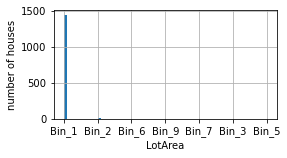

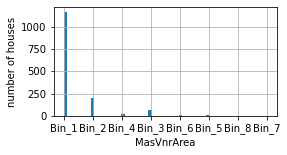

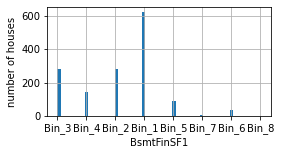

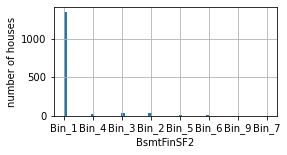

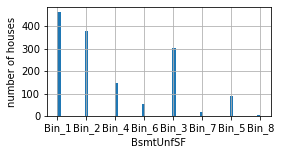

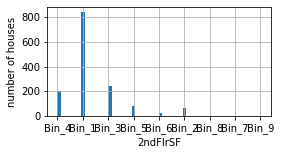

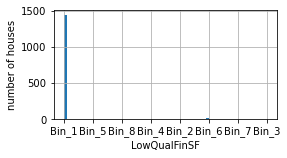

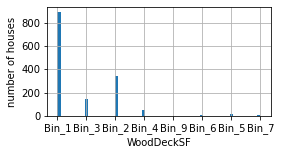

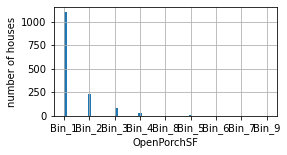

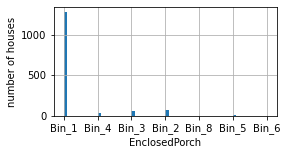

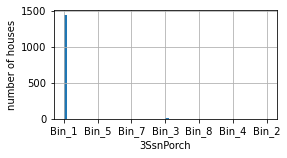

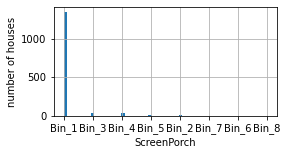

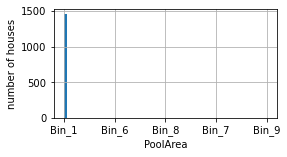

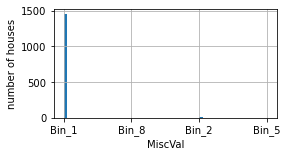

In [29]:
for var in vars_to_discret:
    plt.figure(figsize=(4,2))
    fig = data[var].hist(bins=60)
    fig.set_ylabel('number of houses')
    fig.set_xlabel(var)

In [30]:
data[vars_to_discret]

,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,2ndFlrSF,LowQualFinSF,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
Id,,,,,,,,,,,,,,
1,Bin_1,Bin_1,Bin_3,Bin_1,Bin_1,Bin_4,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
2,Bin_1,Bin_1,Bin_4,Bin_1,Bin_1,Bin_1,Bin_1,Bin_3,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
3,Bin_1,Bin_1,Bin_2,Bin_1,Bin_2,Bin_4,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
4,Bin_1,Bin_1,Bin_1,Bin_1,Bin_2,Bin_3,Bin_1,Bin_1,Bin_1,Bin_4,Bin_1,Bin_1,Bin_1,Bin_1
5,Bin_1,Bin_2,Bin_3,Bin_1,Bin_2,Bin_5,Bin_1,Bin_2,Bin_2,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,Bin_1,Bin_1,Bin_1,Bin_1,Bin_4,Bin_3,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
1457,Bin_1,Bin_1,Bin_3,Bin_1,Bin_3,Bin_1,Bin_1,Bin_4,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1
1458,Bin_1,Bin_1,Bin_2,Bin_1,Bin_4,Bin_5,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_1,Bin_2


In [31]:
data.shape

(1458, 78)

In [32]:
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

d = defaultdict(LabelEncoder)

# only want to labelEncode nominal, ordinal, and discretized variables!

# fitting to train set
data[ordinal] = data[ordinal].apply(lambda x: d[x.name].fit_transform(x))
data[nominal] = data[nominal].apply(lambda x: d[x.name].fit_transform(x))
data[vars_to_discret] = data[vars_to_discret].apply(lambda x: d[x.name].fit_transform(x))

In [33]:
data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,3,4.189655,0,1,0,3,3,0,4,...,0,0,0,0,2,2,0,2,8,4
2,20,3,4.394449,0,1,0,3,3,0,2,...,0,0,0,0,2,2,0,5,8,4
3,60,3,4.234107,0,1,0,0,3,0,4,...,0,0,0,0,2,2,0,9,8,4
4,70,3,4.110874,0,1,0,0,3,0,0,...,0,0,0,0,2,2,0,2,8,0
5,60,3,4.442651,0,1,0,0,3,0,2,...,0,0,0,0,2,2,0,12,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,3,4.143135,0,1,0,3,3,0,4,...,0,0,0,0,2,2,0,8,8,4
1457,20,3,4.454347,0,1,0,3,3,0,4,...,0,0,0,0,2,2,0,2,8,4
1458,70,3,4.204693,0,1,0,3,3,0,4,...,0,0,0,0,0,2,1,5,8,4


In [34]:
data_encoded = data.copy()

In [35]:
data_encoded.shape

(1458, 78)

In [36]:
from sklearn.feature_selection import VarianceThreshold

# fitting the threshold to all features of Xtrain,
# VarianceThreshold finds all features with values taking 99% and above of the feature space 
sel = VarianceThreshold(threshold=0.05)  
sel.fit(data)

# finding which features have values over the threshold
quasiConstant = data.columns[~sel.get_support()]
print('Features with 1 value taking up 95% or more of the feature space: ', quasiConstant)

#capture feature names of variables we want to keep
featNames = data.columns[sel.get_support()]

#removing the unwanted features
data = sel.transform(data)

# trasnforming back into dataframe
data = pd.DataFrame(data, columns=featNames)

data.shape

Features with 1 value taking up 95% or more of the feature space:  Index(['Street', 'Alley', 'Utilities', 'KitchenAbvGr', 'PoolArea', 'PoolQC',
       'MiscFeature', 'MiscVal'],
      dtype='object')


(1458, 70)

In [37]:
RandomNewVariables = ['NeighborhoodLF', 'NeighborhoodQual_Cond', 'NeighborhoodHS', 'TotalBath', 'OverallExterior']

<AxesSubplot:>

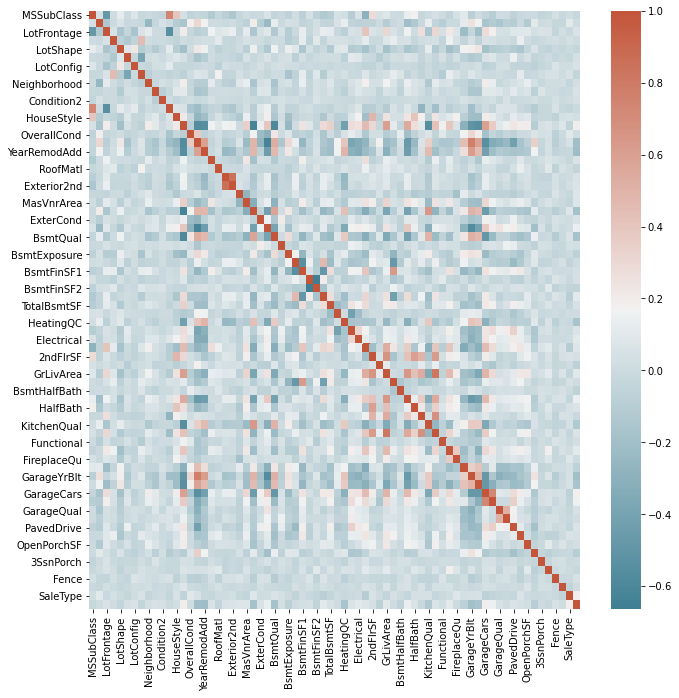

In [38]:
corrmat = data.corr(method='pearson')
cmap = sns.diverging_palette(220, 20, as_cmap=True)
fig, ax = plt.subplots()
fig.set_size_inches(11,11)
sns.heatmap(corrmat, cmap=cmap)

In [39]:
def correlated(df, threshold):
    # create the correlation matrix
    corrMatrix = df.corr()
    
    # for each feature in the dataset (columns of the correlation matrix)
    for i in range(len(corrMatrix.columns)):
        
        # check with other features
        for j in range(i):
            
            # if the correlation is higher than a certain threshold
            if abs(corrMatrix.iloc[i, j]) >= threshold:
                
                # print correlation, and variables examined
                # keep in mind that the columns and rows of the dataframe are identical
                # so we can identify the features being examned by looking for i,j
                # in the column names
                print(abs(corrMatrix.iloc[i, j]), corrMatrix.columns[i], corrMatrix.columns[j])
                

corrFeatures = correlated(data, 0.8)

0.8539259034604927 Exterior2nd Exterior1st
0.8229827843482296 TotRmsAbvGrd GrLivArea


In [40]:
featuresToDrop = ['Exterior1st', 'Exterior2nd', 'TotRmsAbvGrd']
data.drop(labels=featuresToDrop, axis=1, inplace=True)

In [41]:
data.shape

(1458, 67)

In [42]:
print("NA features in data : " + str(data.isnull().values.sum()))

NA features in data : 0


In [43]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(data, target)
mi_scores[::3]  # show a few features with their MI scores

OverallQual      0.573395
GarageCars       0.374614
YearBuilt        0.336249
BsmtQual         0.311832
GarageYrBlt      0.263969
GarageFinish     0.253822
Fireplaces       0.173821
BsmtFinSF1       0.145112
OverallCond      0.123180
MasVnrArea       0.104549
FireplaceQu      0.091715
HouseStyle       0.082725
BedroomAbvGr     0.073939
Electrical       0.050042
BldgType         0.042367
EnclosedPorch    0.022654
BsmtCond         0.018668
GarageCond       0.016139
BsmtHalfBath     0.011939
RoofStyle        0.005677
LotArea          0.004575
Condition2       0.002283
MoSold           0.000000
Name: MI Scores, dtype: float64

In [44]:
data.shape

(1458, 67)

In [45]:
Xtrain, Xtest, ytrain, ytest = train_test_split(data, target, test_size = 0.3, random_state = 0)
print("Xtrain : " + str(Xtrain.shape))
print("Xtest : " + str(Xtest.shape))
print("ytrain : " + str(ytrain.shape))
print("ytest : " + str(ytest.shape))

Xtrain : (1020, 67)
Xtest : (438, 67)
ytrain : (1020,)
ytest : (438,)


In [46]:
# standardizing the datasets

scaler = StandardScaler()
scaler.fit(Xtrain)

trainScaled = scaler.transform(Xtrain)
#testScaled = scaler.transform(Xtest)

trainScaled = pd.DataFrame(trainScaled, columns=Xtrain.columns)
#testScaled = pd.DataFrame(testScaled, columns=Xtest.columns)

In [47]:
Xtrain.shape, Xtest.shape

((1020, 67), (438, 67))

In [48]:
Xtrain.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LandContour,LotConfig,LandSlope,Neighborhood,Condition1,...,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,SaleType,SaleCondition
464,20.0,3.0,4.110874,0.0,3.0,1.0,4.0,1.0,5.0,2.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,8.0,8.0,4.0
1217,50.0,4.0,3.970292,0.0,3.0,3.0,4.0,0.0,3.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,7.0,8.0,4.0
328,75.0,3.0,4.248495,0.0,0.0,0.0,4.0,0.0,3.0,4.0,...,2.0,0.0,0.0,3.0,0.0,0.0,2.0,7.0,8.0,4.0
601,60.0,3.0,4.394449,0.0,0.0,3.0,4.0,0.0,20.0,2.0,...,2.0,1.0,2.0,0.0,0.0,0.0,2.0,2.0,8.0,0.0
1404,85.0,3.0,4.262680,0.0,3.0,3.0,0.0,0.0,5.0,2.0,...,2.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,8.0,4.0


In [49]:
def rmse_cv(model, df, target):
    rmse= np.sqrt(-cross_val_score(model, df, target, scoring = "neg_mean_squared_error", cv = 10))
    return(rmse)

In [50]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)

# Look at predictions on training and validation set
print()
print("RMSE on Training set :", rmse_cv(lr, Xtrain, ytrain).mean())
print("RMSE on Test set :", rmse_cv(lr, Xtest, ytest).mean())
print()

ytrainPred = lr.predict(Xtrain)
ytestPred = lr.predict(Xtest)


RMSE on Training set : 0.12309890680526803
RMSE on Test set : 0.13060204558474697



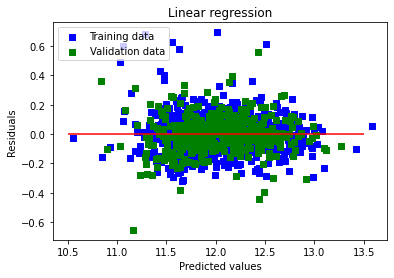

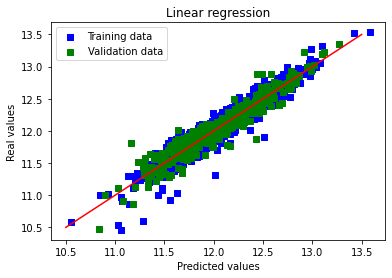

In [51]:
# Plot residuals
plt.scatter(ytrainPred, ytrainPred - ytrain, c = "blue", marker = "s", label = "Training data")
plt.scatter(ytestPred, ytestPred - ytest, c = "green", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(ytrainPred, ytrain, c = "blue", marker = "s", label = "Training data")
plt.scatter(ytestPred, ytest, c = "green", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()